In [1]:
import re
import os
import chardet
import numpy as np
import pandas as pd

import nltk
import textwrap
nltk.download("stopwords")
nltk.download("punkt")
from contractions import contractions_dict
from sklearn.model_selection import train_test_split

from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from scipy import spatial
import networkx as nx

from rouge_score import rouge_scorer
from bert_score import score as bert_score

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kysgattu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kysgattu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def expand_contractions(text, contraction_map=None):
    if contraction_map is None:
        contraction_map = contractions_dict

    # Using regex for getting all contracted words
    contractions_keys = '|'.join(re.escape(key) for key in contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    expanded_text = contractions_pattern.sub(lambda match: contraction_map.get(match.group(0), match.group(0)), text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


In [3]:
# Function to detect file encoding
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

In [4]:
# Set the base directory
base_dir = "data/BBCNewsSummary/News Articles"
output_dir = "data/BBCNewsSummaryCSV"  # Output directory

# Check if the output directory exists, and create it if not
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get the list of classes (subfolder names)
classes = os.listdir(base_dir)
dfs = {}
# Create dataframes and write to CSV files for each class
for class_name in classes:
    # Define the paths for news articles and summaries
    news_articles_path = os.path.join(base_dir, class_name)
    summaries_path = os.path.join("data/BBCNewsSummary/Summaries", class_name)

    # Get the list of file names in both directories
    news_articles_files = os.listdir(news_articles_path)
    summaries_files = os.listdir(summaries_path)

    # Match file names
    common_files = set(news_articles_files) & set(summaries_files)

    # Create dataframe
    df_list = []

    # Read content from files and populate dataframe
    for filename in sorted(common_files):  # Sort by filename
        news_article_file_path = os.path.join(news_articles_path, filename)
        summary_file_path = os.path.join(summaries_path, filename)

        # Detect encoding
        news_encoding = detect_encoding(news_article_file_path)
        summary_encoding = detect_encoding(summary_file_path)

        try:
            with open(news_article_file_path, 'r', encoding=news_encoding) as news_file, \
                    open(summary_file_path, 'r', encoding=summary_encoding) as summary_file:
                news_content = news_file.read()
                summary_content = summary_file.read()
                

                # Extract file name without extension
                file_name_without_extension = os.path.splitext(filename)[0]

                # Generate the new entry in the filename
                new_filename = f'{class_name}_{file_name_without_extension}'

                df_list.append({'filename': new_filename, 'newsarticle': news_content, 'summary': summary_content})

        except UnicodeDecodeError:
            print(f"UnicodeDecodeError: Could not read {filename}. Skipping this file.")

    # Create dataframe from the list and sort by filename
    df = pd.DataFrame(df_list).sort_values(by='filename')
    
    # Save dataframe to the dictionary
    dfs[class_name] = df


    # # Write dataframe to CSV in the output directory
    # csv_filename = os.path.join(output_dir, f'{class_name}_data.csv')
    # df.to_csv(csv_filename, index=False)
    # print(f'Dataframe for {class_name} written to {csv_filename}')


In [5]:
business = dfs['business']
entertainment = dfs['entertainment']
sport = dfs['sport']
politics = dfs['politics']
tech = dfs['tech']

In [6]:
sample_text = business['newsarticle'][242] 

In [7]:
print(sample_text)

Making your office work for you

Our mission to brighten up your working lives continues - and this time, we're taking a long hard look at your offices.

Over the next few months, our panel of experts will be listening to your gripes about where you work, and suggesting ways to make your workspace more efficient, more congenial or simply prettier. This week, we're hearing from Marianne Petersen, who is planning to convert a barn in Sweden into a base for her freelance writing work. Click on the link under her photograph to read her story, and then scroll down to see what the panel have to say. And if you want to take part in the series, go to the bottom of the story to find out how to get in touch.

Working from home presents a multitude of challenges. Understanding your work personality allows you to work in terms of your own style. Do you feel confident about your work output without conferring with others? Are you able to retain discipline and self motivate to get the job done? Do y

In [8]:
# entertainment = pd.read_csv('data/BBCNewsSummaryCSV/entertainment_data.csv') 
# sport = pd.read_csv('data/BBCNewsSummaryCSV/sport_data.csv')
# tech = pd.read_csv('data/BBCNewsSummaryCSV/tech_data.csv')
# business = pd.read_csv('data/BBCNewsSummaryCSV/business_data.csv')
# politics = pd.read_csv('data/BBCNewsSummaryCSV/politics_data.csv')

In [9]:
domain1 = pd.concat([business,tech], ignore_index=True)
domain2 = pd.concat([entertainment,politics], ignore_index=True)

In [10]:
# domain1 = domain1[0:10]
# domain2 = domain2[0:10]

In [11]:
print("Training size:",len(domain1))
print("Testing size:",len(domain2))

Training size: 911
Testing size: 803


In [12]:
domain1 = domain1.sample(frac=1).reset_index(drop=True)
domain2 = domain2.sample(frac=1).reset_index(drop=True)

In [13]:
domain1['newsarticle'] = domain1['newsarticle'].apply(expand_contractions)
domain2['newsarticle'] = domain2['newsarticle'].apply(expand_contractions)

In [14]:
def wrap(x):
    return textwrap.fill(x,replace_whitespace=False,fix_sentence_endings=True)

In [15]:
stop_words = stopwords.words("english")

In [16]:
def textRank(text):
    # Tokenize sentences
    sentences=sent_tokenize(text)
    # Clean and lowercase sentences
    sentences_clean=[re.sub(r'[^\w\s]','',sentence.lower()) for sentence in sentences]
     # Remove stopwords
    stop_words = stopwords.words('english')
    sentence_tokens=[[words for words in sentence.split(' ') if words not in stop_words] for sentence in sentences_clean]
    # Create Word2Vec model
    w2v=Word2Vec(sentence_tokens,vector_size=1,min_count=1,epochs=1000)
    # Get sentence embeddings
    sentence_embeddings=[[w2v.wv[word][0] for word in words] for words in sentence_tokens]
    # Pad embeddings to the maximum sentence length
    max_len=max([len(tokens) for tokens in sentence_tokens])
    # Calculate similarity matrix
    sentence_embeddings=[np.pad(embedding,(0,max_len-len(embedding)),'constant') for embedding in sentence_embeddings]
    similarity_matrix = np.zeros([len(sentence_tokens), len(sentence_tokens)])
    for i,row_embedding in enumerate(sentence_embeddings):
        for j,column_embedding in enumerate(sentence_embeddings):
            similarity_matrix[i][j]=1-spatial.distance.cosine(row_embedding,column_embedding)
    # Create a graph from the similarity matrix
    nx_graph = nx.from_numpy_array(similarity_matrix)
    # Apply PageRank algorithm
    scores = nx.pagerank(nx_graph, max_iter = 600)
    # Get top-ranked sentences
    top_sentence={sentence:scores[index] for index,sentence in enumerate(sentences)}
    top=dict(sorted(top_sentence.items(), key=lambda x: x[1], reverse=True)[:4])
    # Generate the summary
    summary = ''
    for sent in sentences:
        if sent in top.keys():
            summary = summary+sent
            # print(summary)
    return summary

In [17]:
# Function to apply summarizer and calculate scores for each row
def tr_summarize(row):
    news_article = row['newsarticle']
    actual_summary = row['summary']

    # Generate extractive summary
    extractive_summary_str = textRank(news_article)
    
    # Calculate ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])
    rouge_scores = scorer.score(extractive_summary_str, actual_summary)

    # Compute BERT scores
    _, _, bert_f1 = bert_score([extractive_summary_str], [actual_summary], lang='en', model_type='bert-base-uncased')

    return pd.Series({
        'predicted_summary': extractive_summary_str,
        'rouge1_precision': rouge_scores['rouge1'].precision,
        'bert_score': bert_f1.item()
    })


In [18]:
textRank(domain1['newsarticle'][1])

'The Federal Statistics Office said growth for the whole of 2004 was 1.6%, after a year of contraction in 2003, down from an earlier estimate of 1.7%.Major companies including Volkswagen, DaimlerChrysler and Siemens have spent much of 2004 in tough talks with unions about trimming jobs and costs.According to the statistics office, Destatis, rising exports were outweighed in the fourth quarter by the continuing weakness of domestic demand.The ECBs mandate is to fight rising prices by boosting interest rates - and that could further threaten Germanys hopes of recovery.'

In [19]:
textRank(domain2['newsarticle'][1])

'Entertainers could also be liable for fines under the proposed legisation from both US politcians and officials from the Federal Communications Commission (FCC).A Republican senator from Kansas, Sam Brownbeck, is set to call for a maximum $3 million (£1.6 million) fine for repeated violations.Republican politician Fred Upton, who chairs the committee responsible for broadcasting, said current fines are "more of a cost of doing business rather than a deterrent".Certain broadcasters, like Fox, claim the material they carry does not violate indecency laws and is protected under the right to free speech.'

In [20]:
# Apply the process_row function to each row in the DataFrame and concatenate the result_df with the original DataFrame
trOnDomain1 = pd.concat([domain1, domain1.apply(tr_summarize, axis=1)], axis=1)

In [21]:
trOnDomain2 = pd.concat([domain2, domain2.apply(tr_summarize, axis=1)], axis=1)

In [22]:
trOnDomain1.head()

,filename,newsarticle,summary,predicted_summary,rouge1_precision,bert_score
0,tech_023,Lasers help bridge network gaps\n\nAn Indian t...,The laser links also take far less time to set...,In 12 months the lasers have helped the firm s...,0.203883,0.579506
1,business_073,German growth goes into reverse\n\nGermanys ec...,The figures confounded hopes of a 0.2% expansi...,The Federal Statistics Office said growth for ...,0.371681,0.644573
2,business_066,German business confidence slides\n\nGerman bu...,Analysts said that the Ifo figures and Germany...,Economy and Labour Minister Wolfgang Clement c...,0.543307,0.787796
3,tech_289,Mobiles rack up 20 years of use\n\nMobile phon...,Cellnet and Vodafone were the only mobile phon...,Mobiles have become so popular that many peopl...,0.233945,0.586068
4,tech_171,Ultimate game award for Doom 3\n\nSci-fi shoot...,"It was the only title to win twice, winning Ul...",Other winners included Grand Theft Auto: San A...,0.312977,0.595829


In [23]:
trOnDomain2.head()

,filename,newsarticle,summary,predicted_summary,rouge1_precision,bert_score
0,politics_174,Escaped prisoner report ordered\n\nFirst Minis...,The Scottish Executive said ministers would be...,The Scottish Executive said ministers would be...,0.152482,0.585861
1,entertainment_171,US to raise TV indecency fines\n\nUS politicia...,Last year's Janet Jackson 'wardrobe malfunctio...,Entertainers could also be liable for fines un...,0.330579,0.619656
2,entertainment_104,Glasgow hosts tsunami benefit gig\n\nThe top n...,"Colin MacIntyre, of Mull Historical Society, w...","Mull Historical Society, Deacon Blue, Idlewild...",0.594340,0.748921
3,politics_386,Straw backs ending China embargo\n\nUK Foreign...,"Mr Straw, visiting Beijing, noted arms embargo...",China has in the past said it sees the weapons...,0.406504,0.795378
4,politics_158,"Petrol duties frozen, Brown says\n\nChancellor...",Mr Brown told the House that government policy...,Mr Brown told the House that government policy...,0.320896,0.634960


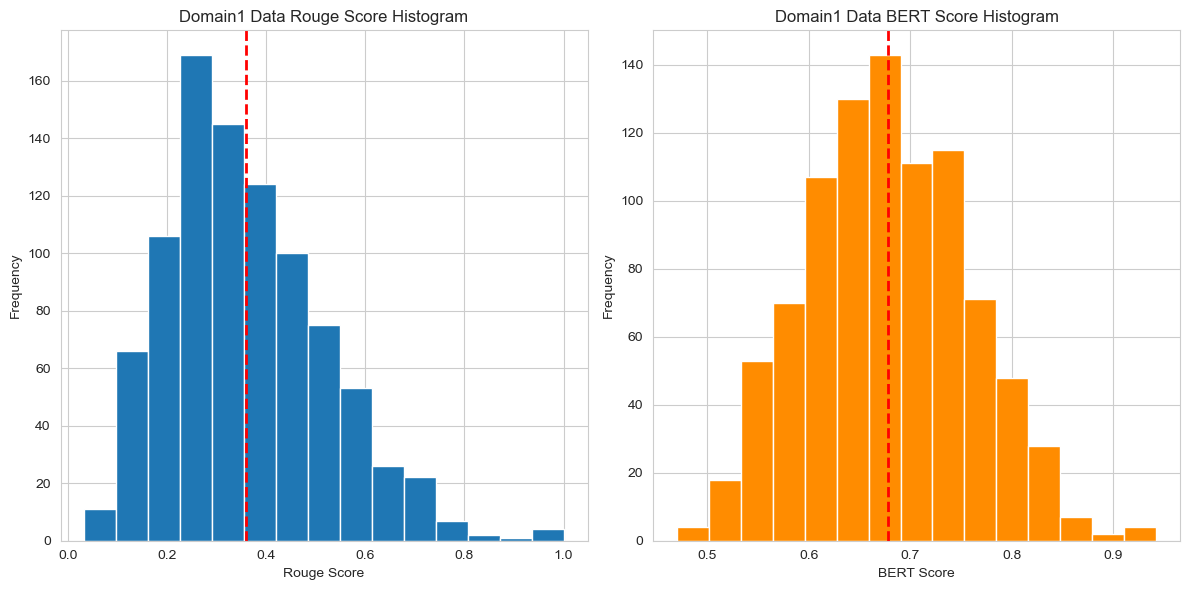

In [30]:
import matplotlib.pyplot as plt

# Calculate mean values
sameCat_mean_rouge = np.mean(trOnDomain1['rouge1_precision'])
sameCat_mean_bert = np.mean(trOnDomain1['bert_score'])


# Create separate histogram plots for Rouge and BERT Scores
plt.figure(figsize=(12, 6))
# plt.title('Same Category Data')

# Rouge Score Histogram
plt.subplot(1, 2, 1)
plt.hist(trOnDomain1['rouge1_precision'], bins=15, color='#1f77b4')
plt.axvline(sameCat_mean_rouge, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {sameCat_mean_rouge:.3f}')
plt.title('Domain1 Data Rouge Score Histogram')
plt.xlabel('Rouge Score')
plt.ylabel('Frequency')

# BERT Score Histogram
plt.subplot(1, 2, 2)
plt.hist(trOnDomain1['bert_score'], bins=15, color='darkorange')
plt.axvline(sameCat_mean_bert, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {sameCat_mean_bert:.3f}')
plt.title('Domain1 Data BERT Score Histogram')
plt.xlabel('BERT Score')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [32]:
sameCat_mean_bert

0.6777311390108387

In [33]:
sameCat_mean_rouge

0.35930884492724635

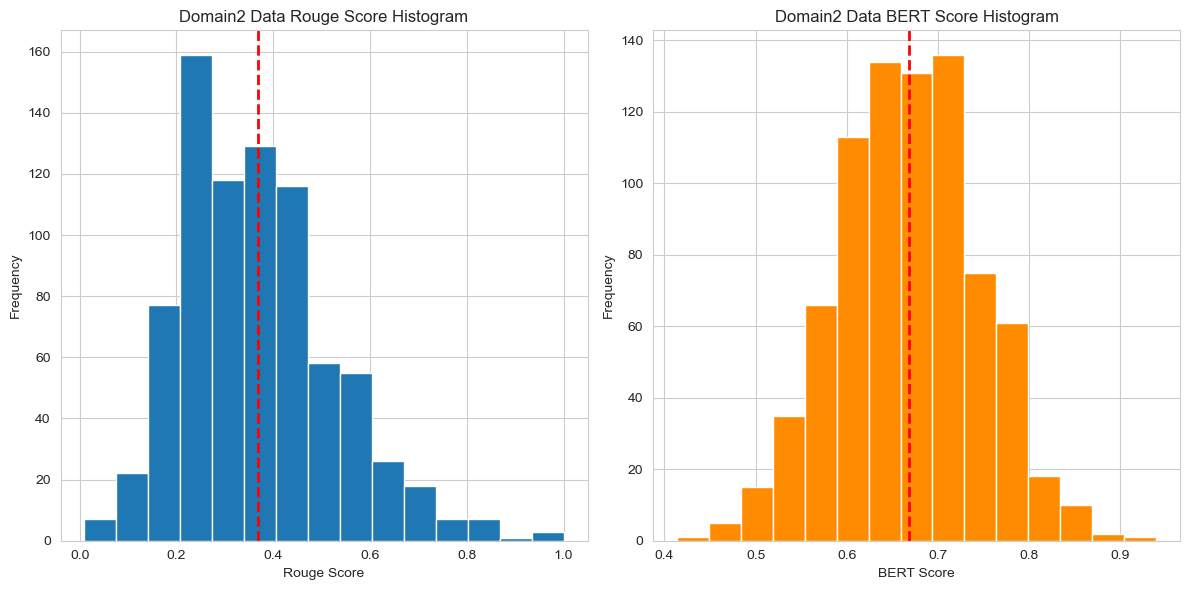

In [27]:
import matplotlib.pyplot as plt

# Calculate mean values
sameCat_mean_rouge = np.mean(trOnDomain2['rouge1_precision'])
sameCat_mean_bert = np.mean(trOnDomain2['bert_score'])


# Create separate histogram plots for Rouge and BERT Scores
plt.figure(figsize=(12, 6))
# plt.title('Same Category Data')

# Rouge Score Histogram
plt.subplot(1, 2, 1)
plt.hist(trOnDomain2['rouge1_precision'], bins=15, color='#1f77b4')
plt.axvline(sameCat_mean_rouge, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {sameCat_mean_rouge:.3f}')
plt.title('Domain2 Data Rouge Score Histogram')
plt.xlabel('Rouge Score')
plt.ylabel('Frequency')

# BERT Score Histogram
plt.subplot(1, 2, 2)
plt.hist(trOnDomain2['bert_score'], bins=15, color='darkorange')
plt.axvline(sameCat_mean_bert, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {sameCat_mean_bert:.3f}')
plt.title('Domain2 Data BERT Score Histogram')
plt.xlabel('BERT Score')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


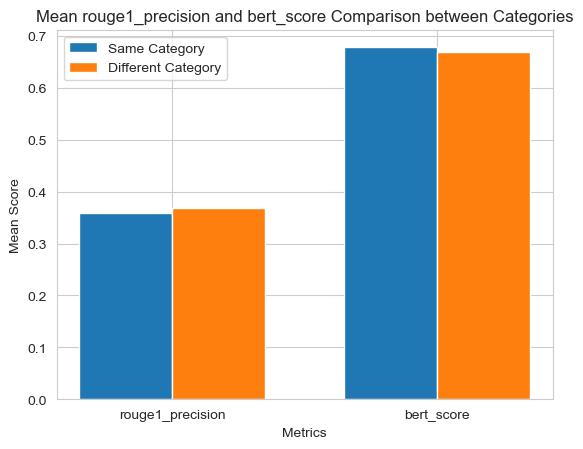

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual data)
same_category_mean_rouge1 = trOnDomain1['rouge1_precision'].mean()
same_category_mean_bert = trOnDomain1['bert_score'].mean()

diff_category_mean_rouge1 = trOnDomain2['rouge1_precision'].mean()
diff_category_mean_bert = trOnDomain2['bert_score'].mean()

categories = ['rouge1_precision', 'bert_score']
mean_scores_same_category = [same_category_mean_rouge1, same_category_mean_bert]
mean_scores_diff_category = [diff_category_mean_rouge1, diff_category_mean_bert]

bar_width = 0.35
index = np.arange(len(categories))

fig, ax = plt.subplots()
bar1 = ax.bar(index, mean_scores_same_category, bar_width, label='Same Category')
bar2 = ax.bar(index + bar_width, mean_scores_diff_category, bar_width, label='Different Category')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Score')
ax.set_title('Mean rouge1_precision and bert_score Comparison between Categories')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()

# Show the plot
plt.show()


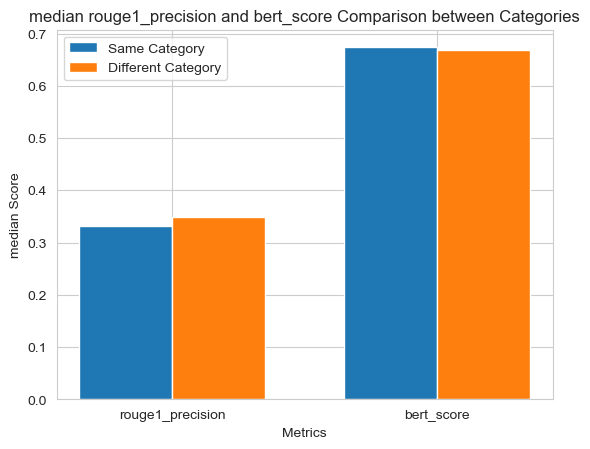

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual data)
same_category_median_rouge1 = trOnDomain1['rouge1_precision'].median()
same_category_median_bert = trOnDomain1['bert_score'].median()

diff_category_median_rouge1 = trOnDomain2['rouge1_precision'].median()
diff_category_median_bert = trOnDomain2['bert_score'].median()

categories = ['rouge1_precision', 'bert_score']
median_scores_same_category = [same_category_median_rouge1, same_category_median_bert]
median_scores_diff_category = [diff_category_median_rouge1, diff_category_median_bert]

bar_width = 0.35
index = np.arange(len(categories))

fig, ax = plt.subplots()
bar1 = ax.bar(index, median_scores_same_category, bar_width, label='Same Category')
bar2 = ax.bar(index + bar_width, median_scores_diff_category, bar_width, label='Different Category')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('median Score')
ax.set_title('median rouge1_precision and bert_score Comparison between Categories')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()

# Show the plot
plt.show()

In [31]:
get_ipython().system('jupyter nbconvert --to script TextRank-ExtractiveSummarizer.ipynb')

[NbConvertApp] Converting notebook TextRank-ExtractiveSummarizer.ipynb to script
[NbConvertApp] Writing 12684 bytes to TextRank-ExtractiveSummarizer.py
